# Milk Quality Prediction
Collaborative course project worked with 2 other students in the UBC MDS Program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


## Data Loading and Modification

In [2]:
milk = pd.read_csv("milknew.csv")

## Data Exploration

In [3]:
print("Basic Information：")
print(milk.info())
print("\nStatistic Information：")
print(milk.describe())

Basic Information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB
None

Statistic Information：
                pH   Temprature        Taste         Odor         Fat   \
count  1059.000000  1059.000000  1059.000000  1059.000000  1059.000000   
mean      6.630123    44.226629     0.546742     0.432483     0.671388   
std       1.399679    10.098364     0.498046     0.495655     0.469930   
min       3.000000    34.000000     0.000000     0.000000     0.000000   
25%

In [4]:
# check for missing value
print(milk.isnull().sum())

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64



Distribution of Grade：
Grade
low       429
medium    374
high      256
Name: count, dtype: int64


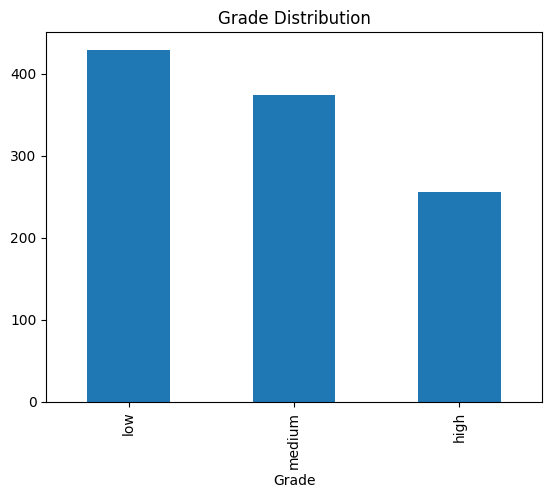

In [5]:
milk.columns = milk.columns.str.strip()

#Distribution of Grade
print("\nDistribution of Grade：")
print(milk['Grade'].value_counts())
milk['Grade'].value_counts().plot(kind='bar', title='Grade Distribution')
plt.show()

numerical features: ['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour']


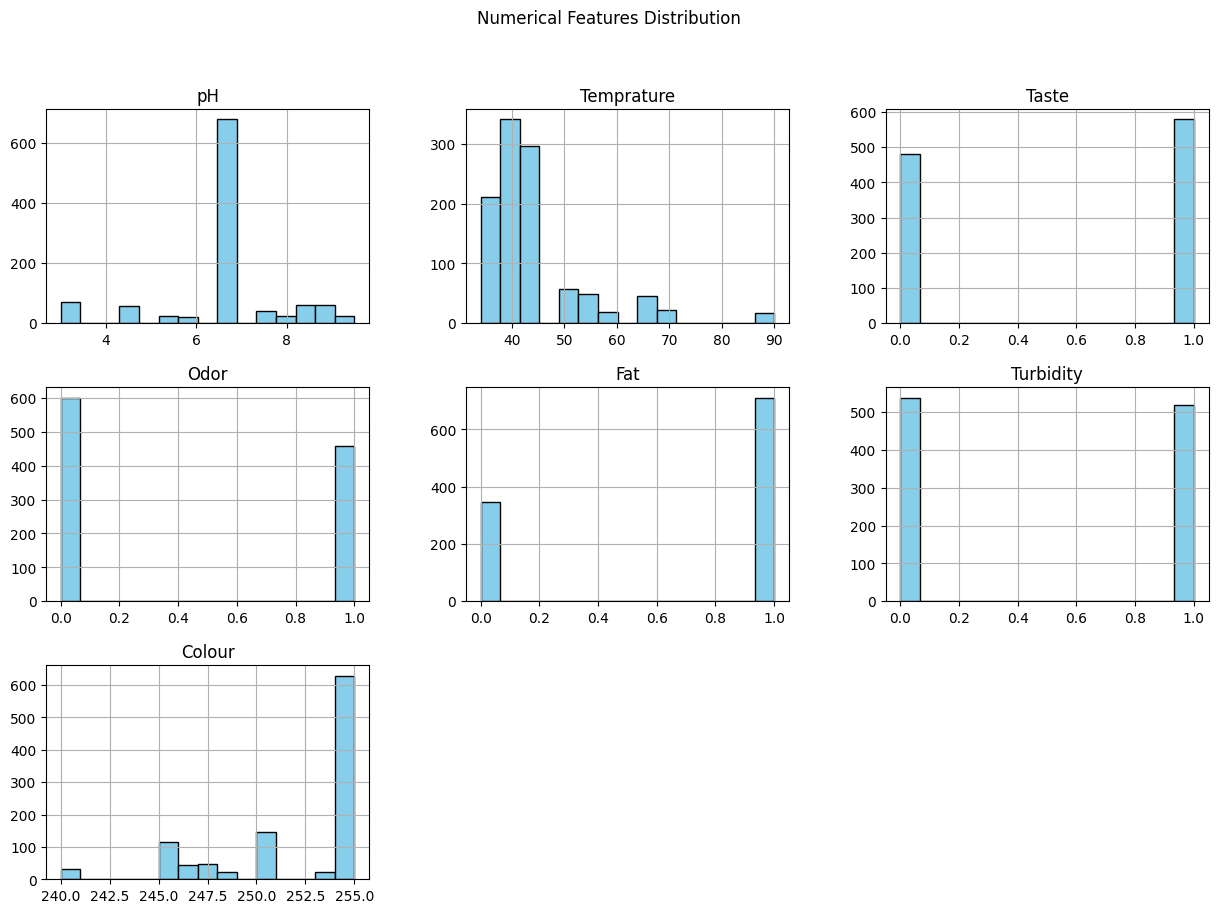


Features grouped by Grade：
              pH  Temprature     Taste      Odor       Fat  Turbidity  \
Grade                                                                   
high    6.692578   40.648438  0.664062  0.750000  0.996094   0.632812   
low     6.588578   50.289044  0.592075  0.477855  0.727273   0.724942   
medium  6.635027   39.721925  0.414439  0.163102  0.385027   0.125668   

            Colour  
Grade               
high    252.539062  
low     252.734266  
medium  250.336898  


In [6]:
# find the numerical features
numerical_features = milk.select_dtypes(include=[np.number]).columns.tolist()
print(f"numerical features: {numerical_features}")

# plot the distribution of features 
milk[numerical_features].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Numerical Features Distribution')
plt.show()

print("\nFeatures grouped by Grade：")
print(milk.groupby('Grade')[numerical_features].mean())

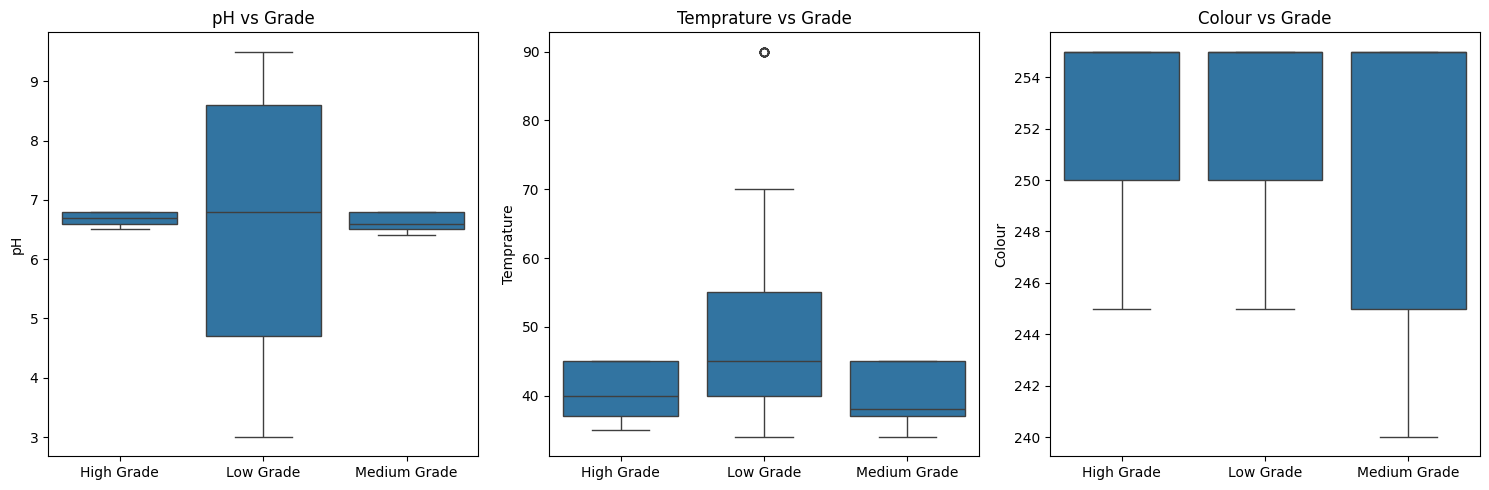

In [7]:
# boxplot for continuous features
selected_features = ['pH', 'Temprature', 'Colour']

plt.figure(figsize=(15, 5)) 
for i, feature in enumerate(selected_features, 1):
    plt.subplot(1, 3, i)  
    sns.boxplot(x='Grade', y=feature, data=milk)
    plt.title(f'{feature} vs Grade')
    plt.xlabel('')  
    plt.xticks(ticks=[0, 1, 2], labels=['High Grade', 'Low Grade', 'Medium Grade'])  
plt.tight_layout()
plt.show()

                  pH  Temprature     Taste      Odor       Fat  Turbidity  \
pH          1.000000    0.244684 -0.064053 -0.081331 -0.093429   0.048384   
Temprature  0.244684    1.000000 -0.109792 -0.048870  0.024073   0.185106   
Taste      -0.064053   -0.109792  1.000000  0.017582  0.324149   0.055755   
Odor       -0.081331   -0.048870  0.017582  1.000000  0.314505   0.457935   
Fat        -0.093429    0.024073  0.324149  0.314505  1.000000   0.329264   
Turbidity   0.048384    0.185106  0.055755  0.457935  0.329264   1.000000   
Colour     -0.164565   -0.008511 -0.082654 -0.039361  0.114151   0.136436   

              Colour  
pH         -0.164565  
Temprature -0.008511  
Taste      -0.082654  
Odor       -0.039361  
Fat         0.114151  
Turbidity   0.136436  
Colour      1.000000  


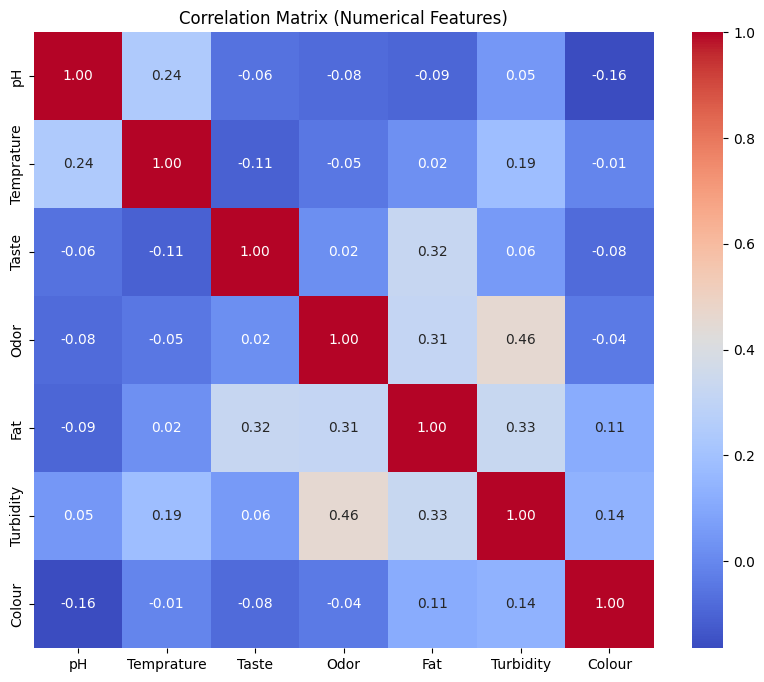

In [8]:
# find the correlation among features
correlation_matrix = milk[numerical_features].corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

In [9]:
# count the number of duplicates
duplicates = milk.duplicated()  
print(duplicates)

num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

0       False
1       False
2       False
3       False
4       False
        ...  
1054     True
1055     True
1056     True
1057     True
1058     True
Length: 1059, dtype: bool
Number of duplicate rows: 976


## Data Preprocesing For Model Fitting

In [10]:
# split the response variable
x = milk.drop('Grade', axis=1) 

# convert the vategorical values of y into ordinal values
mapping = {'high': 2, 'medium': 1, 'low': 0}
y = milk['Grade'].map(mapping)

In [11]:
# split the data into 80% training set and 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

##### Standardized data

In [12]:
scaler1 = StandardScaler()
x_train_sdl = scaler1.fit_transform(x_train)
x_test_sdl = scaler1.transform(x_test)

##### Normalized data

In [13]:
scaler2 = MinMaxScaler()
x_train_nml = scaler2.fit_transform(x_train)
x_test_nml = scaler2.transform(x_test)

## Logistic Regression

### Preprocessing  - Baseline

In [14]:
# Logistic Regression----with normalized data
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression.fit(x_train_nml, y_train)

y_pred_logistic = logistic_regression.predict(x_test_nml)

training_logistic_nml = logistic_regression.score(x_train_nml, y_train)
print(f"Training Set Accuracy: {training_logistic_nml}")

test_logistic_nml = accuracy_score(y_test, y_pred_logistic)
print(f"Test Accuracy: {test_logistic_nml}")

Training Set Accuracy: 0.8040141676505312
Test Accuracy: 0.7641509433962265


In [15]:
# Logistic Regression----with Standardized data
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression.fit(x_train_sdl, y_train)

y_pred_logistic = logistic_regression.predict(x_test_sdl)

training_logistic_sdl = logistic_regression.score(x_train_sdl, y_train)
print(f"Training Set Accuracy: {training_logistic_sdl}")

test_logistic_sdl = accuracy_score(y_test, y_pred_logistic)
print(f"Test Accuracy: {test_logistic_sdl}")

Training Set Accuracy: 0.8583234946871311
Test Accuracy: 0.839622641509434


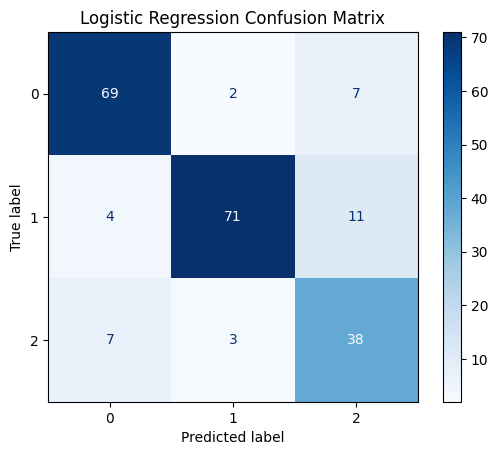

In [16]:
# confusion matrix for model on standardized data 
conf_m_logistic = confusion_matrix(y_test, y_pred_logistic)
conf_logistic = ConfusionMatrixDisplay(confusion_matrix=conf_m_logistic)

conf_logistic.plot(cmap="Blues")  
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### Hyperparameter Tuning

In [17]:
# Define parameter grid for Logistic Regression
tune_grid_logistic = {
    'C': [0.01, 1, 10, 100],       # Regularization strength
    'penalty': ['l1', 'l2'],       # Penalty type
    'solver': ['liblinear', 'saga','lbfgs'] 
}

In [18]:
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Grid Search for Logistic Regression, cv = 3
kf_log_3 = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search_logistic_3 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=tune_grid_logistic,
    cv=kf_log_3,
    scoring='accuracy'
)

# Fit the Grid Search
grid_search_logistic_3.fit(x_train_sdl, y_train)

results_3_log = pd.DataFrame(grid_search_logistic_3.cv_results_)
#display(results_3_log)

print("Top Ranked Parameter Combinations:")
top_results_3_log = results_3_log[results_3_log["rank_test_score"] == 1]
display(top_results_3_log)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.010536,0.001434,0.000826,0.000066,1.0,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
10,0.003271,0.000321,0.000614,0.000069,1.0,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
11,0.003303,0.000171,0.000619,0.000021,1.0,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
13,0.071065,0.022087,0.000988,0.000061,10.0,l1,saga,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
16,0.007038,0.001938,0.000872,0.000018,10.0,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
17,0.004176,0.000135,0.000983,0.000320,10.0,l2,lbfgs,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.862191,0.85461,0.879433,0.865411,0.010387,1
23,0.004097,0.000639,0.000686,0.000042,100.0,l2,lbfgs,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.862191,0.85461,0.879433,0.865411,0.010387,1


In [19]:
# Grid Search for Logistic Regression, cv = 5
kf_log_5 = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_logistic_5 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=tune_grid_logistic,
    cv=kf_log_5,
    scoring='accuracy'
)

# Fit the Grid Search
grid_search_logistic_5.fit(x_train_sdl, y_train)

results_5_log = pd.DataFrame(grid_search_logistic_5.cv_results_)
#display(results_5_log)

print("Top Ranked Parameter Combinations:")
top_results_5_log = results_5_log[results_5_log["rank_test_score"] == 1]
display(top_results_5_log)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.011936,0.001277,0.000873,0.000130,1.0,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.847059,0.876471,0.869822,0.816568,0.863905,0.854765,0.021447,1
10,0.004075,0.000505,0.000830,0.000240,1.0,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.847059,0.876471,0.869822,0.816568,0.863905,0.854765,0.021447,1
11,0.003803,0.001004,0.000657,0.000081,1.0,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.847059,0.876471,0.869822,0.816568,0.863905,0.854765,0.021447,1
16,0.012914,0.008689,0.001495,0.000596,10.0,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.847059,0.876471,0.869822,0.816568,0.863905,0.854765,0.021447,1
17,0.006099,0.001649,0.000895,0.000124,10.0,l2,lbfgs,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.847059,0.876471,0.869822,0.816568,0.863905,0.854765,0.021447,1


In [20]:
# Grid Search for Logistic Regression, cv = 7
kf_log_7 = KFold(n_splits=7, shuffle=True, random_state=42) 

grid_search_logistic_7 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=tune_grid_logistic,
    cv=kf_log_7,
    scoring='accuracy'
)

# Fit the Grid Search
grid_search_logistic_7.fit(x_train_sdl, y_train)

results_7_log = pd.DataFrame(grid_search_logistic_7.cv_results_)
#display(results_7_log)

print("Top Ranked Parameter Combinations:")
top_results_7_log = results_7_log[results_7_log["rank_test_score"] == 1]
display(top_results_7_log)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
7,0.011454,0.001125,0.000838,0.000179,1.0,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.867769,0.834711,0.892562,0.867769,0.818182,0.884298,0.859504,0.860685,0.024368,1
10,0.003800,0.000379,0.000675,0.000116,1.0,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.867769,0.834711,0.892562,0.867769,0.818182,0.884298,0.859504,0.860685,0.024368,1


In [21]:
# Grid Search for Logistic Regression, cv = 10
kf_log_10 = KFold(n_splits=10, shuffle=True, random_state=42) 

grid_search_logistic_10 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=tune_grid_logistic,
    cv=kf_log_10,
    scoring='accuracy'
)

# Fit the Grid Search
grid_search_logistic_10.fit(x_train_sdl, y_train)

results_10_log = pd.DataFrame(grid_search_logistic_10.cv_results_)
#display(results_10_log)

print("Top Ranked Parameter Combinations:")
top_results_10_log = results_10_log[results_10_log["rank_test_score"] == 1]
display(top_results_10_log)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,0.003820,0.000450,0.000694,0.000160,1.0,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.835294,0.858824,...,0.870588,0.894118,0.847059,0.8,0.857143,0.869048,0.857143,0.857157,0.024844,1
11,0.004119,0.000691,0.000808,0.000266,1.0,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.835294,0.858824,...,0.870588,0.894118,0.847059,0.8,0.857143,0.869048,0.857143,0.857157,0.024844,1


##### choose best tuning parameers when cv = 5

In [22]:
tune_logistic = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=1000, random_state=42)
tune_logistic.fit(x_train_sdl, y_train)

y_pred_logistic_best = tune_logistic.predict(x_test_sdl)
test_accuracy_tune_log = accuracy_score(y_test, y_pred_logistic_best)
print(f"Test Accuracy: {test_accuracy_tune_log}")

Test Accuracy: 0.839622641509434


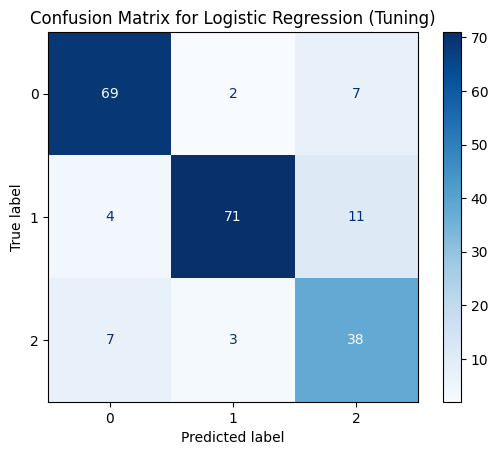

In [23]:
conf_tune_logistic = confusion_matrix(y_test, y_pred_logistic_best)
conf_tune_logistic_disp = ConfusionMatrixDisplay(confusion_matrix=conf_tune_logistic, display_labels=tune_logistic.classes_)

conf_tune_logistic_disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression (Tuning)")
plt.show()

In [24]:
# classification report
grade = ["low", "medium", "high"] 
report_logistic_best = classification_report(y_test, y_pred_logistic_best, target_names=grade)
print(report_logistic_best)

              precision    recall  f1-score   support

         low       0.86      0.88      0.87        78
      medium       0.93      0.83      0.88        86
        high       0.68      0.79      0.73        48

    accuracy                           0.84       212
   macro avg       0.83      0.83      0.83       212
weighted avg       0.85      0.84      0.84       212



### Full Data Modelling

In [25]:
# full data cv 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold5_accuracy_log = [] 
y_predictions_log = []   
y_true_log = []

for train_index, test_index in kf.split(x):
    x_train_in, x_test_in = x.iloc[train_index], x.iloc[test_index]
    y_train_in, y_test_in = y[train_index], y[test_index]

    x_train_full = scaler1.fit_transform(x_train_in)
    x_test_full = scaler1.transform(x_test_in)

    logistic_final = LogisticRegression(C=1, penalty='l1',solver='saga', random_state=42, max_iter=1000)
    logistic_final.fit(x_train_full, y_train_in)

    y_pred_full = logistic_final.predict(x_test_full)
    y_predictions_log.extend(y_pred_full)
    y_true_log.extend(y_test_in)

    accuracy = accuracy_score(y_test_in, y_pred_full)
    fold5_accuracy_log.append(accuracy)

In [26]:
mean_acc_log = np.mean(fold5_accuracy_log)
print(f"Average accuracy (full data): {mean_acc_log}")

Average accuracy (full data): 0.8526960565143522


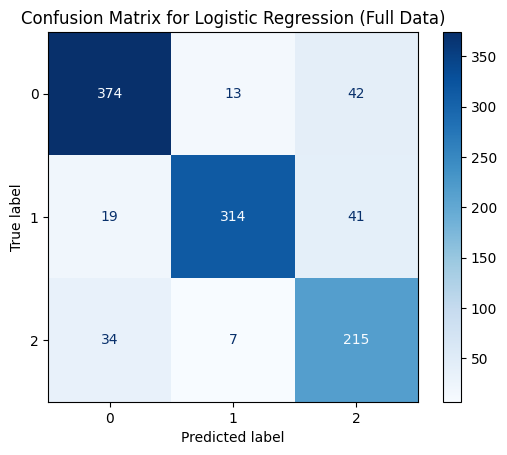

In [27]:
best_cm_log = confusion_matrix(y_true_log, y_predictions_log)
conf_best_log = ConfusionMatrixDisplay(confusion_matrix=best_cm_log)

conf_best_log.plot(cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression (Full Data)")
plt.show()

## K-nearest Neighbour Classifier (KNN)

### Preprocessing  - Baseline

In [28]:
# KNN----with normalized data
knn = KNeighborsClassifier(n_neighbors=5,weights="uniform")
knn.fit(x_train_nml, y_train)

y_pred_knn = knn.predict(x_test_nml)

test_knn_nml = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy: {test_knn_nml}")

class_report_knn = classification_report(y_test, y_pred_knn)
print("Classification Report:\n", class_report_knn)

Test Accuracy: 0.9764150943396226
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       1.00      1.00      1.00        86
           2       0.96      0.94      0.95        48

    accuracy                           0.98       212
   macro avg       0.97      0.97      0.97       212
weighted avg       0.98      0.98      0.98       212



In [29]:
# KNN----with standardized data
knn = KNeighborsClassifier(n_neighbors=5,weights="uniform")
knn.fit(x_train_sdl, y_train)

y_pred_knn = knn.predict(x_test_sdl)

test_knn_sdl = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy: {test_knn_sdl}")

class_report_knn = classification_report(y_test, y_pred_knn)
print("Classification Report:\n", class_report_knn)

Test Accuracy: 0.9764150943396226
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       0.99      1.00      0.99        86
           2       0.98      0.94      0.96        48

    accuracy                           0.98       212
   macro avg       0.98      0.97      0.97       212
weighted avg       0.98      0.98      0.98       212



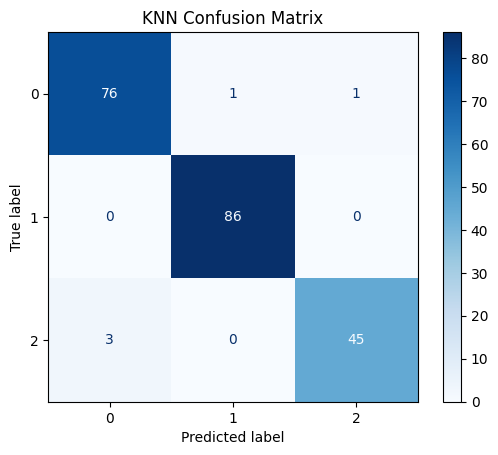

In [30]:
# confusion matrix for model on standardized data 
conf_m_knn = confusion_matrix(y_test, y_pred_knn)
conf_knn = ConfusionMatrixDisplay(confusion_matrix=conf_m_knn)

conf_knn.plot(cmap="Blues")  
plt.title("KNN Confusion Matrix")
plt.show()

### Hyperparameter Tuning

In [31]:
# Define parameter grid for KNN
tune_grid_knn = {
    'n_neighbors': [i for i in range(3, 51)],   #try different k
    'weights': ['distance']                     #try different weightings method
}

In [32]:
# Grid Search for KNN, cv = 3
grid_search_knn_3 = GridSearchCV(KNeighborsClassifier(n_neighbors=5,weights="uniform"), tune_grid_knn, cv=3, scoring='accuracy', n_jobs=-1,return_train_score=True)

# Fit the Grid Search
grid_search_knn_3.fit(x_train_sdl, y_train)

results_3_knn = pd.DataFrame(grid_search_knn_3.cv_results_)
#display(results_3_knn)

print("Top Ranked Parameter Combinations:")
top_results_3_knn = results_3_knn[results_3_knn["rank_test_score"] == 1]
display(top_results_3_knn)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.003956,0.001472,0.008318,0.005877,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0
1,0.003560,0.000541,0.003861,0.000427,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0
2,0.002803,0.000583,0.004329,0.000517,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0
3,0.002495,0.000306,0.004240,0.000463,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0
4,0.002672,0.000960,0.003765,0.000191,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0
5,0.006108,0.004181,0.004280,0.000307,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",1.0,0.989362,1.0,0.996454,0.005015,1,1.0,1.0,1.0,1.0,0.0


In [33]:
# Grid Search for KNN, cv = 5
grid_search_knn_5 = GridSearchCV(KNeighborsClassifier(n_neighbors=5,weights="uniform"), tune_grid_knn, cv=5, scoring='accuracy', n_jobs=-1,return_train_score=True)

# Fit the Grid Search
grid_search_knn_5.fit(x_train_sdl, y_train)

results_5_knn = pd.DataFrame(grid_search_knn_5.cv_results_)
#display(results_5_knn)

print("Top Ranked Parameter Combinations:")
top_results_5_knn = results_5_knn[results_5_knn["rank_test_score"] == 1]
display(top_results_5_knn)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001857,0.000302,0.002217,0.000159,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.001883,0.000185,0.002559,0.000571,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.002001,0.000051,0.002882,0.000254,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.002099,0.000033,0.002885,0.000118,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.002356,0.000439,0.003192,0.000456,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.002251,0.000260,0.002971,0.000141,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.002120,0.000089,0.003412,0.000466,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.002238,0.000314,0.003324,0.000462,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
40,0.002214,0.000111,0.007157,0.002155,43,distance,"{'n_neighbors': 43, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41,0.002147,0.000379,0.006032,0.000619,44,distance,"{'n_neighbors': 44, 'weights': 'distance'}",1.0,1.0,0.994083,...,0.998817,0.002367,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [34]:
# Grid Search for KNN, cv = 7
grid_search_knn_7 = GridSearchCV(KNeighborsClassifier(n_neighbors=5,weights="uniform"), tune_grid_knn, cv=7, scoring='accuracy', n_jobs=-1,return_train_score=True)

# Fit the Grid Search
grid_search_knn_7.fit(x_train_sdl, y_train)

results_7_knn = pd.DataFrame(grid_search_knn_7.cv_results_)
#display(results_7_knn)

print("Top Ranked Parameter Combinations:")
top_results_7_knn = results_7_knn[results_7_knn["rank_test_score"] == 1]
display(top_results_7_knn)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,mean_train_score,std_train_score
0,0.001771,0.000084,0.001935,0.000086,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.002209,0.000468,0.002545,0.000804,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.002137,0.000160,0.002738,0.000399,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.002252,0.000282,0.003113,0.000670,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.002612,0.000776,0.003193,0.000823,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.002198,0.000083,0.002831,0.000215,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.002815,0.000974,0.003934,0.001828,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.002196,0.000122,0.003492,0.001352,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
42,0.002506,0.000052,0.005672,0.000218,45,distance,"{'n_neighbors': 45, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
43,0.002888,0.000319,0.005804,0.000191,46,distance,"{'n_neighbors': 46, 'weights': 'distance'}",1.0,1.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [35]:
# Grid Search for KNN, cv = 10
grid_search_knn_10 = GridSearchCV(KNeighborsClassifier(n_neighbors=5,weights="uniform"), tune_grid_knn, cv=10, scoring='accuracy', n_jobs=-1,return_train_score=True)

# Fit the Grid Search
grid_search_knn_10.fit(x_train_sdl, y_train)

results_10_knn = pd.DataFrame(grid_search_knn_10.cv_results_)
#display(results_10_knn)

print("Top Ranked Parameter Combinations:")
top_results_10_knn = results_10_knn[results_10_knn["rank_test_score"] == 1]
display(top_results_10_knn)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004071,0.004002,0.003448,0.001128,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.002771,0.000301,0.003332,0.001106,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.002922,0.000485,0.003400,0.000718,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.003183,0.000832,0.003160,0.000528,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.003406,0.000755,0.003487,0.001189,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.002801,0.000145,0.003757,0.001897,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.003304,0.001040,0.003280,0.000324,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,0.003149,0.000836,0.004097,0.001229,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,0.003452,0.000905,0.003808,0.001026,11,distance,"{'n_neighbors': 11, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,0.003403,0.001076,0.003869,0.001336,12,distance,"{'n_neighbors': 12, 'weights': 'distance'}",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


##### Similar performance for cv = 5, 7, 10. Choose the best parameters when cv = 5 to avoid overfitting on the training set

In [36]:
best_knn = grid_search_knn_5.best_estimator_
y_pred_knn_best = best_knn.predict(x_test_sdl)
test_accuracy_tune_knn = accuracy_score(y_test, y_pred_knn_best)
print(f"Test Accuracy: {test_accuracy_tune_knn}")

Test Accuracy: 0.9952830188679245


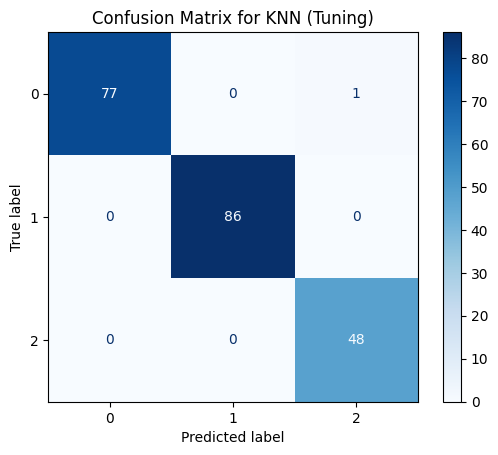

In [37]:
conf_tune_knn = confusion_matrix(y_test, y_pred_knn_best)
conf_tune_knn_disp = ConfusionMatrixDisplay(confusion_matrix=conf_tune_knn)

conf_tune_knn_disp.plot(cmap="Blues")
plt.title("Confusion Matrix for KNN (Tuning)")
plt.show()

In [38]:
# classification report
grade = ["low", "medium", "high"] 
report_knn_best = classification_report(y_test, y_pred_knn_best, target_names=grade)
print(report_knn_best)

              precision    recall  f1-score   support

         low       1.00      0.99      0.99        78
      medium       1.00      1.00      1.00        86
        high       0.98      1.00      0.99        48

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



##### Parameter Analysis: k (number of neighbours)

In [39]:
#try best models from grid search CV with train set and test on test set
accuracy_results_knn = []
for _, row in top_results_5_knn.iterrows():
    best_params = row["params"]  # Extract parameter dictionary
    
    knn_try_tune = KNeighborsClassifier(**best_params)
    knn_try_tune.fit(x_train_sdl, y_train)
    
    y_pred_tune_knn = knn_try_tune.predict(x_test_sdl)

    acc_knn = accuracy_score(y_test, y_pred_tune_knn)
    accuracy_results_knn.append({"Params": best_params, "Test Accuracy": acc_knn})

# Convert to DataFrame for visualization
accuracy_df_knn = pd.DataFrame(accuracy_results_knn)
final_param_knn = accuracy_df_knn[accuracy_df_knn["Test Accuracy"] == accuracy_df_knn["Test Accuracy"].max()]
final_param_knn

,Params,Test Accuracy
0,"{'n_neighbors': 3, 'weights': 'distance'}",0.995283
1,"{'n_neighbors': 4, 'weights': 'distance'}",0.995283
2,"{'n_neighbors': 5, 'weights': 'distance'}",0.995283
3,"{'n_neighbors': 6, 'weights': 'distance'}",0.995283
4,"{'n_neighbors': 7, 'weights': 'distance'}",0.995283
5,"{'n_neighbors': 8, 'weights': 'distance'}",0.995283
6,"{'n_neighbors': 9, 'weights': 'distance'}",0.995283
7,"{'n_neighbors': 10, 'weights': 'distance'}",0.995283


In [40]:
#create a new col for plotting
accuracy_df_knn["index"] = [i+3 for i in range(len(accuracy_df_knn))]

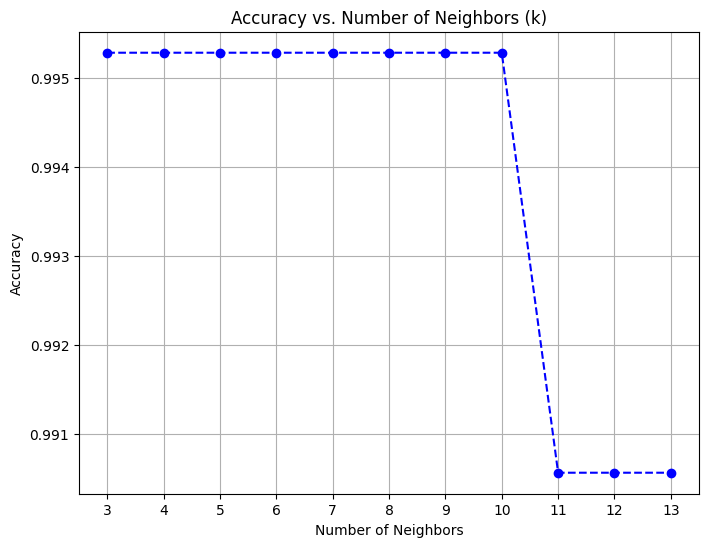

In [41]:
#create plot of accuracy against number of neighbours (k)

neighbors = tune_grid_knn['n_neighbors']
plt.figure(figsize=(8, 6))
plt.plot(accuracy_df_knn["index"][:11], accuracy_df_knn["Test Accuracy"][:11], marker='o', linestyle='--', color='b')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neighbors[:11])
plt.grid()
plt.show()

### Full Data Modelling

##### When k = 3

In [42]:
# full data cv (k = 3)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold5_accuracy_knn_3 = [] 
y_predictions_knn_3 = []   
y_true_knn_3 = []

for train_index, test_index in kf.split(x):
    x_train_in, x_test_in = x.iloc[train_index], x.iloc[test_index]
    y_train_in, y_test_in = y[train_index], y[test_index]

    x_train_full = scaler1.fit_transform(x_train_in)
    x_test_full = scaler1.transform(x_test_in)

    knn_final_3 = KNeighborsClassifier(n_neighbors=3, weights='distance')
    knn_final_3.fit(x_train_full, y_train_in)

    y_pred_full = knn_final_3.predict(x_test_full)
    y_predictions_knn_3.extend(y_pred_full)
    y_true_knn_3.extend(y_test_in)

    accuracy = accuracy_score(y_test_in, y_pred_full)
    fold5_accuracy_knn_3.append(accuracy)

In [43]:
mean_acc_knn_3 = np.mean(fold5_accuracy_knn_3)
print(f"Average accuracy (full data): {mean_acc_knn_3}")

Average accuracy (full data): 0.9981087364750068


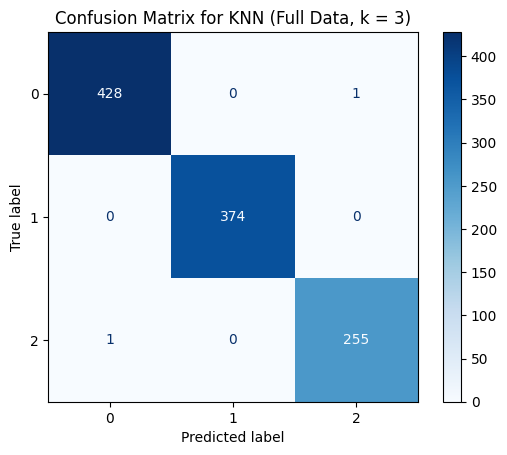

In [44]:
best_cm_knn_3 = confusion_matrix(y_true_knn_3, y_predictions_knn_3)
conf_best_knn_3 = ConfusionMatrixDisplay(confusion_matrix=best_cm_knn_3)

conf_best_knn_3.plot(cmap="Blues")
plt.title("Confusion Matrix for KNN (Full Data, k = 3)")
plt.show()

##### When k = 10

In [45]:
# full data cv (k = 10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold5_accuracy_knn_10 = [] 
y_predictions_knn_10 = []   
y_true_knn_10 = []

for train_index, test_index in kf.split(x):
    x_train_in, x_test_in = x.iloc[train_index], x.iloc[test_index]
    y_train_in, y_test_in = y[train_index], y[test_index]

    x_train_full = scaler1.fit_transform(x_train_in)
    x_test_full = scaler1.transform(x_test_in)

    knn_final_10 = KNeighborsClassifier(n_neighbors=10, weights='distance')
    knn_final_10.fit(x_train_full, y_train_in)

    y_pred_full = knn_final_10.predict(x_test_full)
    y_predictions_knn_10.extend(y_pred_full)
    y_true_knn_10.extend(y_test_in)

    accuracy = accuracy_score(y_test_in, y_pred_full)
    fold5_accuracy_knn_10.append(accuracy)

In [46]:
mean_acc_knn_10 = np.mean(fold5_accuracy_knn_10)
print(f"Average accuracy (full data): {mean_acc_knn_10}")

Average accuracy (full data): 0.999056603773585


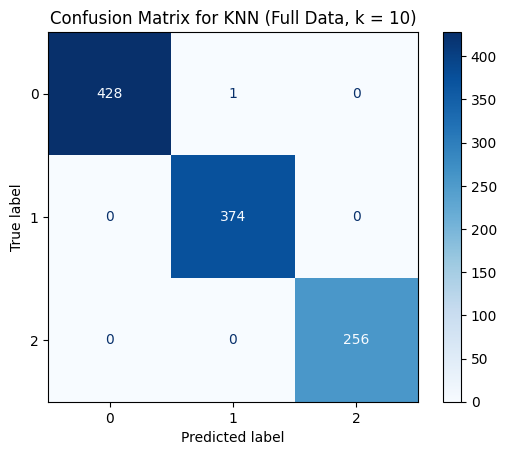

In [47]:
best_cm_knn_10 = confusion_matrix(y_true_knn_10, y_predictions_knn_10)
conf_best_knn_10 = ConfusionMatrixDisplay(confusion_matrix=best_cm_knn_10)

conf_best_knn_10.plot(cmap="Blues")
plt.title("Confusion Matrix for KNN (Full Data, k = 10)")
plt.show()

## Random Forest

### Preprocessing  - Baseline

In [48]:
# Random Forest----with orignial data
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train3, y_train3)

y_pred_rf = rf.predict(x_test3)

test_rf_o = accuracy_score(y_test3, y_pred_rf)
print(f"Test Accuracy: {test_rf_o}")

Test Accuracy: 0.9952830188679245


In [49]:
# Random Forest----with normalized data
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_nml, y_train)

y_pred_rf = rf.predict(x_test_nml)

test_rf_nml = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy: {test_rf_nml}")

class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", class_report_rf)

Test Accuracy: 0.9952830188679245
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       1.00      1.00      1.00        86
           2       0.98      1.00      0.99        48

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



In [50]:
# Random Forest----with standardized data
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_sdl, y_train)

y_pred_rf = rf.predict(x_test_sdl)

test_rf_sdl = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy: {test_rf_sdl}")

class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", class_report_rf)

Test Accuracy: 0.9952830188679245
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       1.00      1.00      1.00        86
           2       0.98      1.00      0.99        48

    accuracy                           1.00       212
   macro avg       0.99      1.00      0.99       212
weighted avg       1.00      1.00      1.00       212



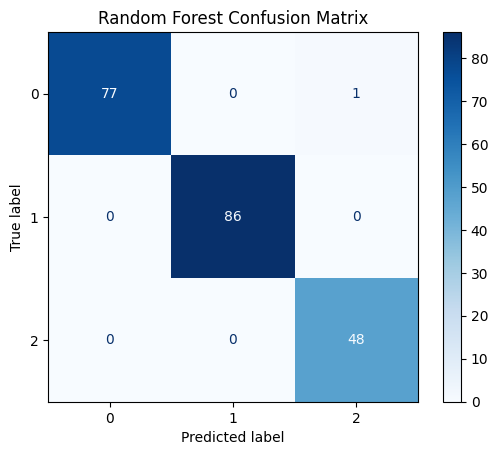

In [51]:
# confusion matrix for model on standardized data 
conf_m_rf = confusion_matrix(y_test, y_pred_rf)
conf_rf = ConfusionMatrixDisplay(confusion_matrix=conf_m_rf)

conf_rf.plot(cmap="Blues")  
plt.title("Random Forest Confusion Matrix")
plt.show()

### Hyperparameter Tuning

In [52]:
# Define parameter grid for Random Forest
tune_grid_rf = {
    'max_depth': [3, 5, 10, 15, None],         # Maximum depth of each decision tree
    'n_estimators': [25, 50, 100, 150, 200],   # Number of decision trees in the forest
    'min_samples_leaf': [1, 2, 5, 10],         # Minimum number of samples required in a leaf node
    'criterion': ['gini', 'entropy']           # Splitting strategy
    }

In [53]:
# Grid Search for Random Forest, cv = 3
grid_search_rf_3 = GridSearchCV(RandomForestClassifier(random_state=42), tune_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)

# Fit the Grid Search
grid_search_rf_3.fit(x_train_sdl, y_train)

results_3_rf = pd.DataFrame(grid_search_rf_3.cv_results_)
#display(results_3_knn)

print("Top Ranked Parameter Combinations:")
top_results_3_rf = results_3_rf[results_3_rf["rank_test_score"] == 1]
display(top_results_3_rf)

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
140,0.073326,0.001618,0.006011,0.000900,entropy,10,1,25,"{'criterion': 'entropy', 'max_depth': 10, 'min...",1.0,0.996454,0.996454,0.997636,0.001672,1,1.0,1.0,1.0,1.0,0.0
160,0.071312,0.005054,0.006057,0.000756,entropy,15,1,25,"{'criterion': 'entropy', 'max_depth': 15, 'min...",1.0,0.996454,0.996454,0.997636,0.001672,1,1.0,1.0,1.0,1.0,0.0
180,0.067981,0.002142,0.006059,0.000139,entropy,None,1,25,"{'criterion': 'entropy', 'max_depth': None, 'm...",1.0,0.996454,0.996454,0.997636,0.001672,1,1.0,1.0,1.0,1.0,0.0


In [54]:
# Grid Search for Random Forest, cv = 5
grid_search_rf_5 = GridSearchCV(RandomForestClassifier(random_state=42), tune_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)

# Fit the Grid Search
grid_search_rf_5.fit(x_train_sdl, y_train)

results_5_rf = pd.DataFrame(grid_search_rf_5.cv_results_)
#display(results_3_knn)

print("Top Ranked Parameter Combinations:")
top_results_5_rf = results_5_rf[results_5_rf["rank_test_score"] == 1]
display(top_results_5_rf.head())
print("Number of best-performing parameter combinations:", top_results_5_rf.shape[0])

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
40,0.090434,0.012317,0.008411,0.002754,gini,10,1,25,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,0.997633,0.002899,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41,0.151157,0.004861,0.008555,0.000315,gini,10,1,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,0.997633,0.002899,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
42,0.284794,0.021017,0.016089,0.001683,gini,10,1,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,0.997633,0.002899,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
43,0.478850,0.053874,0.028289,0.005691,gini,10,1,150,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,0.997633,0.002899,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
44,0.615964,0.048353,0.035090,0.005044,gini,10,1,200,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,0.997633,0.002899,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Number of best-performing parameter combinations: 60


In [55]:
# Grid Search for Random Forest, cv = 7
grid_search_rf_7 = GridSearchCV(RandomForestClassifier(random_state=42), tune_grid_rf, cv=7, scoring='accuracy', n_jobs=-1, return_train_score=True)

# Fit the Grid Search
grid_search_rf_7.fit(x_train_sdl, y_train)

results_7_rf = pd.DataFrame(grid_search_rf_7.cv_results_)
#display(results_7_rf)

print("Top Ranked Parameter Combinations:")
top_results_7_rf = results_7_rf[results_7_rf["rank_test_score"] == 1]
display(top_results_7_rf.head())
print("Number of best-performing parameter combinations:", top_results_7_rf.shape[0])

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,mean_train_score,std_train_score
40,0.074059,0.008467,0.005372,0.001393,gini,10,1,25,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41,0.152980,0.007526,0.008512,0.000849,gini,10,1,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
42,0.298638,0.016633,0.016405,0.002349,gini,10,1,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
43,0.459615,0.022112,0.025213,0.002005,gini,10,1,150,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
44,0.654185,0.045203,0.038051,0.008172,gini,10,1,200,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Number of best-performing parameter combinations: 61


In [56]:
# Grid Search for Random Forest, cv = 10
grid_search_rf_10 = GridSearchCV(RandomForestClassifier(random_state=42), tune_grid_rf, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True)

# Fit the Grid Search
grid_search_rf_10.fit(x_train_sdl, y_train)

results_10_rf = pd.DataFrame(grid_search_rf_10.cv_results_)
#display(results_10_rf)

print("Top Ranked Parameter Combinations:")
top_results_10_rf = results_10_rf[results_10_rf["rank_test_score"] == 1]
display(top_results_10_rf.head())
print("Number of best-performing parameter combinations:", top_results_10_rf.shape[0])

Top Ranked Parameter Combinations:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
40,0.067991,0.002088,0.005525,0.000570,gini,10,1,25,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41,0.147647,0.013401,0.008143,0.000451,gini,10,1,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
42,0.266547,0.009923,0.014331,0.001147,gini,10,1,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
43,0.399175,0.017304,0.020564,0.000705,gini,10,1,150,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
44,0.531934,0.020538,0.026636,0.002270,gini,10,1,200,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Number of best-performing parameter combinations: 52


##### The output of best-performing parameter combinations for tuning with cv = 5, 7, 10 are very similar. Choose the best parameters for cv = 5 to avoid overfitting on the training set

In [57]:
# apply all best parameters on the test set  
accuracy_results_rf = []

for _, row in top_results_5_rf.iterrows():
    best_params_rf = row["params"]  # Extract parameter dictionary
    
    # Train model with these parameters
    rf_try_tune = RandomForestClassifier(**best_params_rf, random_state=42)
    rf_try_tune.fit(x_train_sdl, y_train)

    y_pred_tune_rf = rf_try_tune.predict(x_test_sdl)
    
    acc_rf = accuracy_score(y_test, y_pred_tune_rf)
    accuracy_results_rf.append({"Params": best_params_rf, "Test Accuracy": acc_rf})

# Convert to DataFrame for visualization
accuracy_df = pd.DataFrame(accuracy_results_rf)

In [58]:
acc_param_rf = accuracy_df["Params"].apply(pd.Series)
rf_df = pd.concat([acc_param_rf, accuracy_df["Test Accuracy"]], axis=1)
final_param_rf = rf_df[rf_df["Test Accuracy"] == rf_df["Test Accuracy"].max()]
final_param_rf

,criterion,max_depth,min_samples_leaf,n_estimators,Test Accuracy
0,gini,10.0,1,25,0.995283
1,gini,10.0,1,50,0.995283
2,gini,10.0,1,100,0.995283
3,gini,10.0,1,150,0.995283
4,gini,10.0,1,200,0.995283
10,gini,15.0,1,25,0.995283
11,gini,15.0,1,50,0.995283
12,gini,15.0,1,100,0.995283
13,gini,15.0,1,150,0.995283
14,gini,15.0,1,200,0.995283


##### Parameter Analysis: min_samples_leaf

In [59]:
# apply different value of min_samples_leaf and compare the train and test accuracy
rf_try_train = []
rf_try_test = []
min_leaf = []

for i in range(1, 11):
    min_leaf.append(i)

    rf_try = RandomForestClassifier(min_samples_leaf=i, max_depth=10, n_estimators=100, random_state=42)
    rf_try.fit(x_train_sdl, y_train)

    rf_try_train_pred = rf_try.predict(x_train_sdl)
    rf_try_train_acc = accuracy_score(y_train, rf_try_train_pred)
    rf_try_train.append(rf_try_train_acc)

    rf_try_test_pred = rf_try.predict(x_test_sdl)
    rf_try_test_acc = accuracy_score(y_test, rf_try_test_pred)
    rf_try_test.append(rf_try_test_acc)

rf_try_df = pd.DataFrame({'Train Accuracy': rf_try_train, 'Test Accuracy': rf_try_test, 'min_leaf': min_leaf})
rf_try_df

,Train Accuracy,Test Accuracy,min_leaf
0,1.000000,0.995283,1
1,0.997639,0.990566,2
2,0.997639,0.990566,3
3,0.997639,0.990566,4
4,0.997639,0.990566,5
5,0.997639,0.990566,6
6,0.997639,0.990566,7
7,0.997639,0.990566,8
8,0.997639,0.990566,9
9,0.995277,0.976415,10


In [60]:
# plot the accuracies with different values of min_samples_leaf
try_plot = alt.Chart(rf_try_df).transform_fold(
    ["Train Accuracy", "Test Accuracy"],
    as_=["Metric", "Accuracy"]
).mark_line(point=True).encode(
    x=alt.X("min_leaf:Q", title="min_samples_leaf"),
    y=alt.Y("Accuracy:Q", title="Accuracy", scale=alt.Scale(domain=[0.975, 1.001])),
    color="Metric:N",
).properties(
    title="Effect of min_samples_leaf on Train and Test Accuracy",
    width=500,
    height=300
)

try_plot

alt.Chart(...)

In [61]:
# fit the model with the best parameter
rf_best = RandomForestClassifier(min_samples_leaf=1, random_state=42)
rf_best.fit(x_train_sdl, y_train)

y_pred_best_rf = rf_best.predict(x_test_sdl)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Test Accuracy (after tuning):", accuracy_best_rf)

Test Accuracy (after tuning): 0.9952830188679245


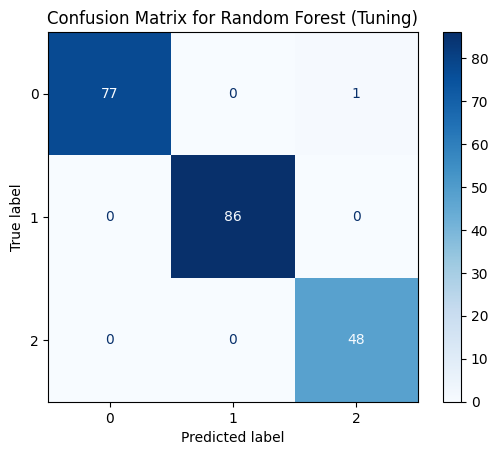

In [62]:
# confusion matrix after tuning
conf_tune_rf = confusion_matrix(y_test, y_pred_best_rf)
conf_tune_rf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_tune_rf)

conf_tune_rf_disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Random Forest (Tuning)")
plt.show()

### Full Model Fitting

In [63]:
# full data cv 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold5_accuracy_rf = [] 
y_predictions_rf = []   
y_true_rf = []
feature_importance_list = []

for train_index, test_index in kf.split(x):
    x_train_in, x_test_in = x.iloc[train_index], x.iloc[test_index]
    y_train_in, y_test_in = y[train_index], y[test_index]

    x_train_full = scaler1.fit_transform(x_train_in)
    x_test_full = scaler1.transform(x_test_in)

    rf_final = RandomForestClassifier(min_samples_leaf=1, random_state=42)
    rf_final.fit(x_train_full, y_train_in)

    y_pred_full = rf_final.predict(x_test_full)
    y_predictions_rf.extend(y_pred_full)
    y_true_rf.extend(y_test_in)

    accuracy = accuracy_score(y_test_in, y_pred_full)
    fold5_accuracy_rf.append(accuracy)

    feature_importance_list.append(rf_final.feature_importances_)

In [64]:
mean_acc_rf = np.mean(fold5_accuracy_rf)
print(f"Average accuracy (full data): {mean_acc_rf}")

Average accuracy (full data): 0.9981087364750068


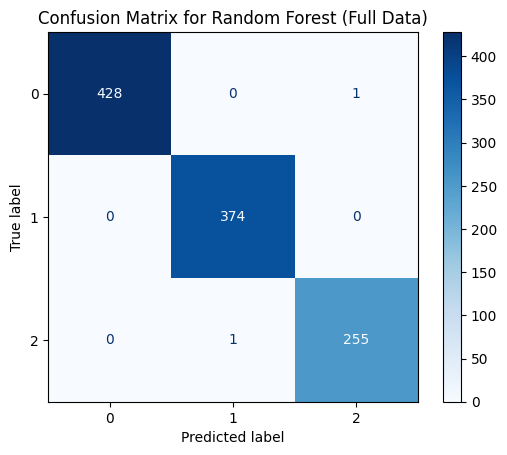

In [65]:
best_cm_rf = confusion_matrix(y_true_rf, y_predictions_rf)
conf_best_rf = ConfusionMatrixDisplay(confusion_matrix=best_cm_rf)

conf_best_rf.plot(cmap="Blues")
plt.title("Confusion Matrix for Random Forest (Full Data)")
plt.show()

##### Feature Importance Analysis

In [66]:
feature_importance_avg = np.mean(feature_importance_list, axis=0)

feature_names = ['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour']

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance_avg
}).sort_values(by="Importance", ascending=False)

In [67]:
feature_plot = alt.Chart(feature_importance_df).mark_bar().encode(
    x=alt.X("Importance:Q", title="Feature Importance Score"),
    y=alt.Y("Feature:N", sort='-x', title="Features"),
).properties(
    title="Feature Importance in Random Forest",
    width=500,
    height=200
)

feature_plot

alt.Chart(...)